### Popular Street Food classification
This dataset from kaggle is an image classification dataset primarily focused on identifying various popular street food items. The core problem it addresses is the automatic recognition and categorization of different street food dishes from images. This can be valuable for applications like building intelligent food recommendation systems, developing mobile apps for food identification, or even for culinary tourism platforms that help users discover local street food specialties.

source: https://www.kaggle.com/datasets/nikolasgegenava/popular-street-foods

In [1]:
import os
import math
import pandas as pd
import numpy as np
import keras
from keras import ops
from keras import layers
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4, ResNet50V2
import matplotlib.pyplot as plt
from PIL import Image
import random # Import the random module


2025-07-07 08:51:38.598064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751878299.555401   37962 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751878299.795539   37962 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751878301.584603   37962 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751878301.584690   37962 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751878301.584693   37962 computation_placer.cc:177] computation placer alr

### Basic EDA
The dataset comes with a stats file listing 20 street food labels along with image count, avg_width, avg_height, min_height, max_height, formats and corrupt files

In [2]:
data_stats = pd.read_csv("dataset_stats.csv")
data_stats

class  image_count  avg_width  avg_height  min_width  \
0               churros          200        135         127         88   
1                gelato          200        145         122         78   
2            currywurst          200        142         121         54   
3                crepes          200        134         128         93   
4               hot_dog          200        143         121         89   
5              shawarma          200        133         129         78   
6        fish_and_chips          200        146         119         84   
7             pani_puri          199        133         127         78   
8                 tacos          198        134         126         92   
9               poutine          196        140         122         91   
10               burger          195        146         121         92   
11            empanadas          180        138         125         89   
12              pretzel          179        130         131         81   
13              falafel          177        130         131         78   
14  kebab_(shish_kebab)          175        137         125         63   
15          pizza_slice          174        146         125         78   
16              bánh_mì          160        147         120         70   
17               arepas          160        144         121         93   
18             pad_thai          160        130         130         93   
19              samosas          158        129         131         78   

    min_height  max_width  max_height    formats  corrupt_files  
0           57        162         140       jpeg              0  
1           55        162         140  jpeg, png              0  
2           63        162         140       jpeg              0  
3           79        162         140       jpeg              0  
4           54        162         140       jpeg              0  
5           85        162         140       jpeg              0  
6           69        162         140       jpeg              0  
7           77        162         140       jpeg              0  
8           63        162         140       jpeg              0  
9           65        162         140       jpeg              0  
10          50        162         140       jpeg              0  
11          68        162         140       jpeg              0  
12          73        162         140       jpeg              0  
13          85        162         140       jpeg              0  
14          59        162         140  jpeg, png              0  
15          72        162         140  jpeg, png              0  
16          63        162         140       jpeg              0  
17          68        162         140       jpeg              0  
18          79        162         140       jpeg              0  
19          90        162         140       jpeg              0

#### Visual inspection of samples


Displaying one random sample image for each class:


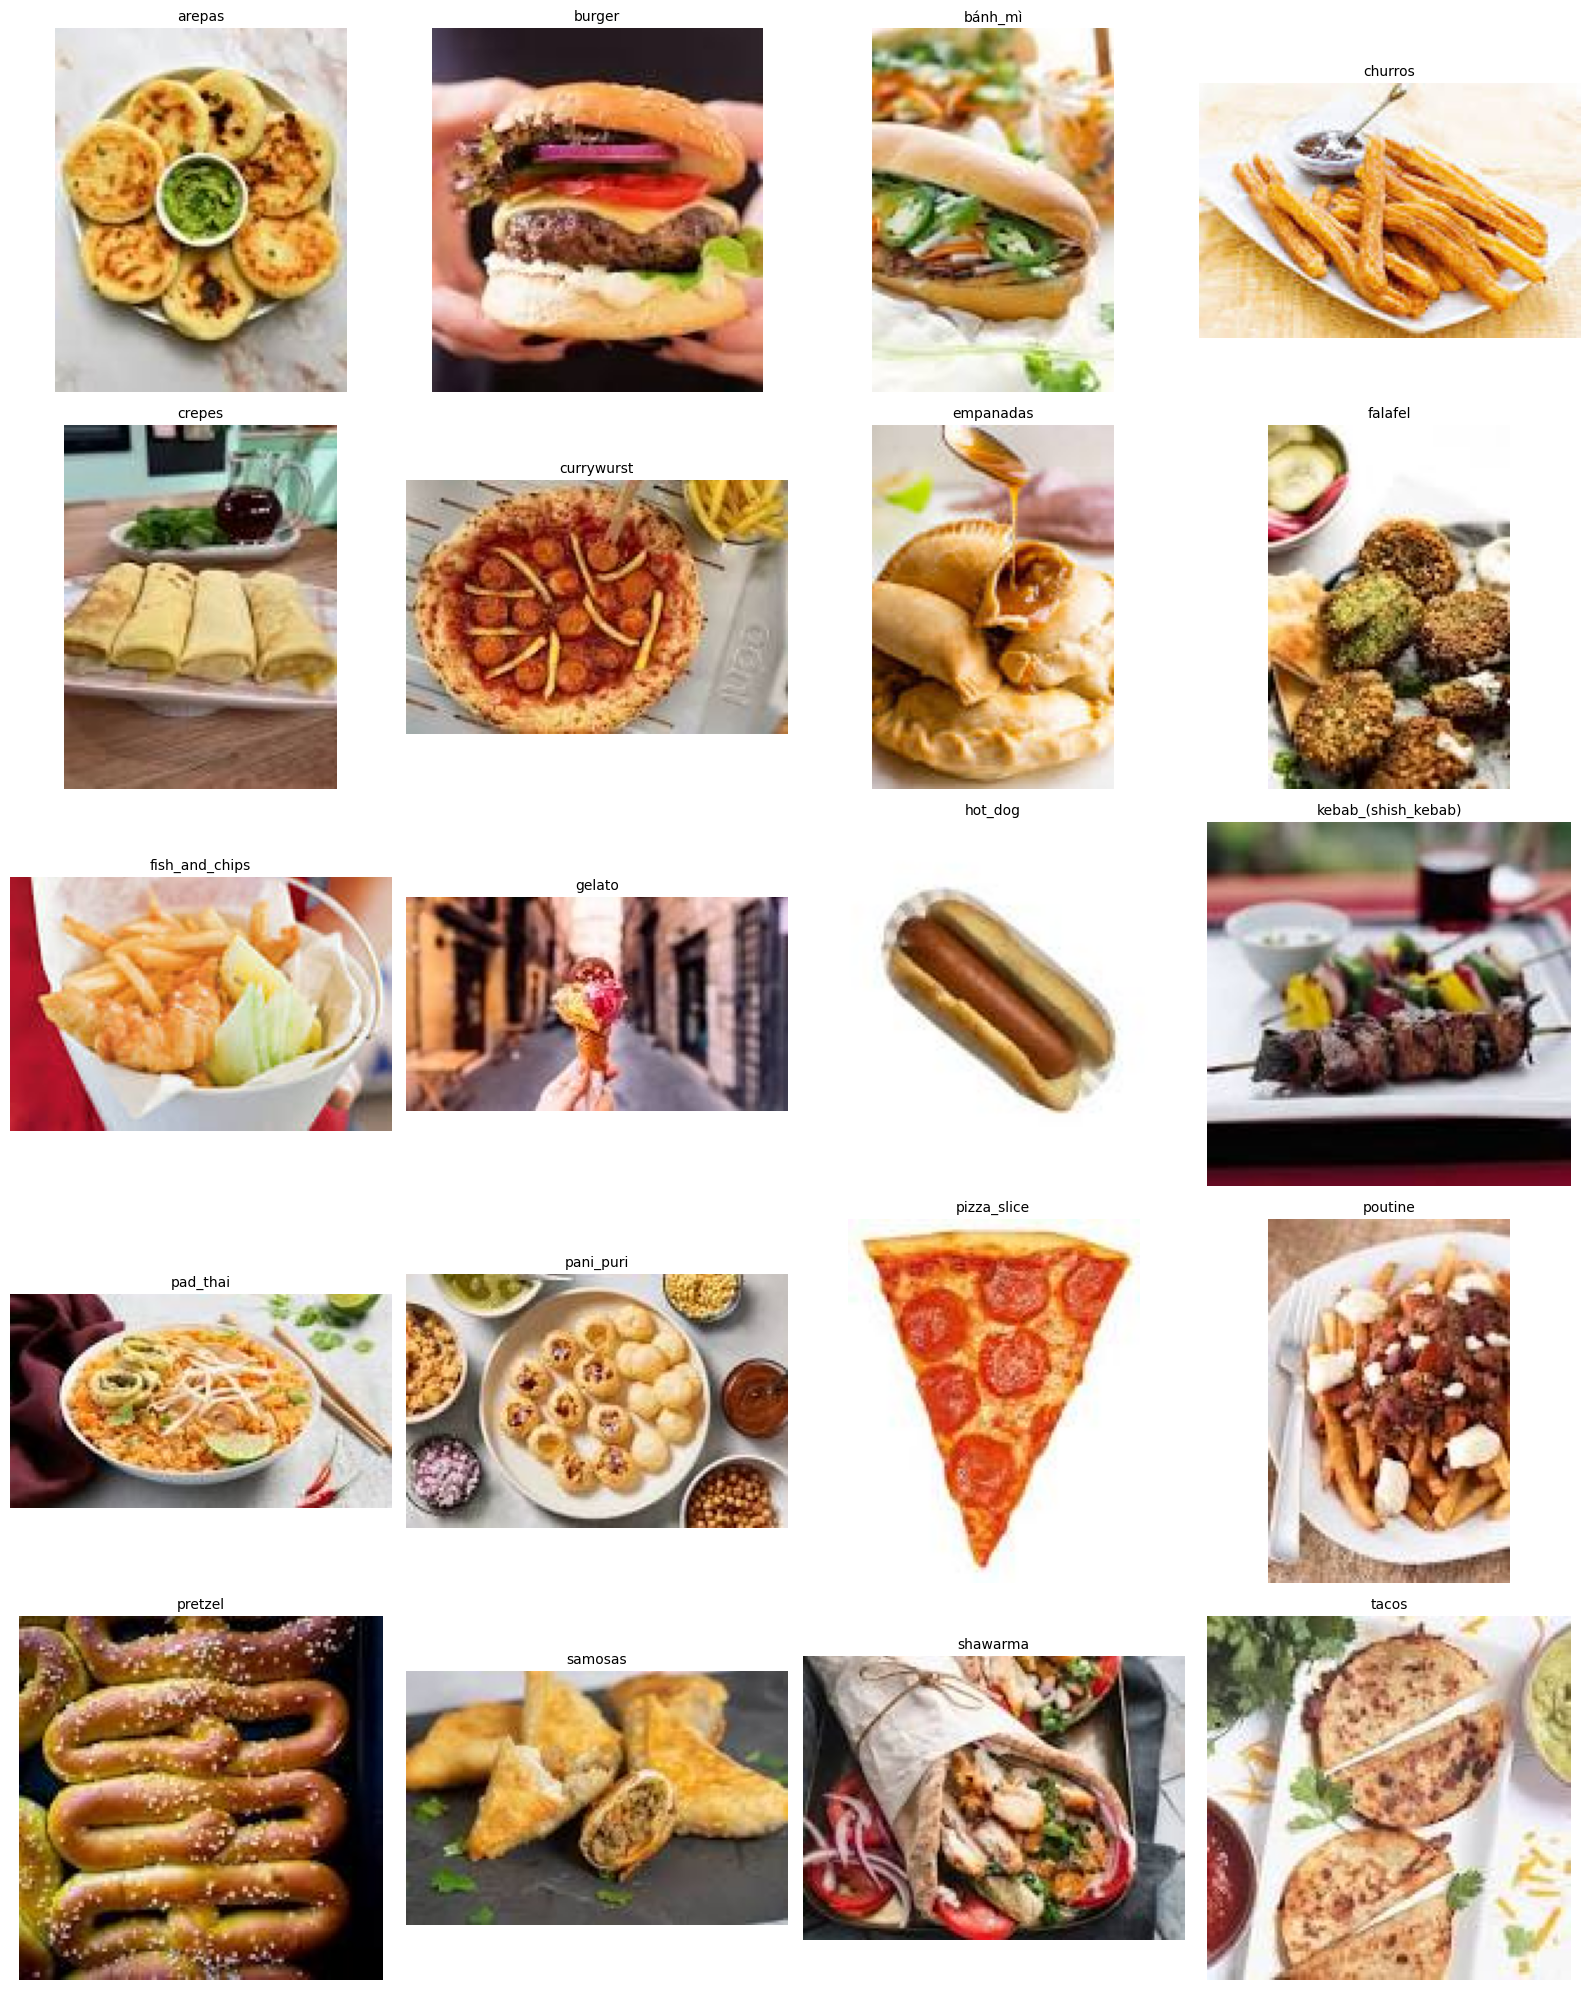

In [3]:
# Define the base data directory
data_dir = "data"

# Dictionary to store one random sample image path per class name (folder name)
sample_images_per_class = {}

# Get a list of all items in the data_dir
# We are looking for subdirectories which represent the class names
class_folders = [
    f for f in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, f))
]

if not class_folders:
    print(f"Error: No class-named subfolders found directly in '{data_dir}'.")
    print("Expected structure: data/CLASS_NAME_1/, data/CLASS_NAME_2/, etc.")
else:
    for class_name in class_folders:
        class_folder_path = os.path.join(data_dir, class_name)
        
        # Collect all image paths in the current class folder
        images_in_folder = []
        for item_name in os.listdir(class_folder_path):
            item_path = os.path.join(class_folder_path, item_name)
            
            # Check if it's an image file
            if os.path.isfile(item_path) and item_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                images_in_folder.append(item_path)
        
        if images_in_folder:
            # Randomly select one image from the collected list
            selected_image_path = random.choice(images_in_folder)
            sample_images_per_class[class_name] = selected_image_path
        else:
            print(f"Warning: No image files found in class folder '{class_name}'.")

    # --- Plotting the sample images ---
    if not sample_images_per_class:
        print("No sample images could be collected from any class folders.")
    else:
        print("\nDisplaying one random sample image for each class:")
        
        num_classes = len(sample_images_per_class)
        
        # Adjust grid size dynamically for better visualization
        cols = int(num_classes**0.5) if num_classes > 0 else 1
        if cols == 0: cols = 1 # Ensure cols is at least 1 for empty or single class case
        
        rows = (num_classes + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4)) # Adjust figsize as needed
        # Flatten axes array for easy iteration, even if it's a single subplot
        axes = axes.flatten() if num_classes > 1 else [axes] 

        # Sort class names for consistent plotting order
        sorted_class_names = sorted(sample_images_per_class.keys())

        for i, class_name in enumerate(sorted_class_names):
            if i >= len(axes): # Safety break if more classes than pre-allocated subplots
                break
            
            img_path = sample_images_per_class[class_name]
            try:
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].set_title(f"{class_name}", fontsize=10, pad=5) # Add padding
                axes[i].axis('off') # Hide axes ticks and labels
            except Exception as e:
                print(f"Error loading or plotting image '{img_path}' for class '{class_name}': {e}")
                axes[i].set_title(f"Error: {class_name}")
                axes[i].axis('off')

        # Hide any unused subplots
        for j in range(num_classes, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
        plt.show()

### Data preparation

In [4]:
# Defining parameters
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 32

# AUGMENTATION
IMG_WIDTH = 32
IMG_HEIGHT = 32
CHANNELS = 3
BATCH_SIZE = 64
NUM_CLASSES = 20

IMAGE_SIZE = IMG_WIDTH
PATCH_SIZE = 4
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 12
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [5]:
train_ds, val_ds= tf.keras.preprocessing.image_dataset_from_directory("data", color_mode="rgb", subset="both", validation_split=0.1, seed=2025, image_size=(IMG_HEIGHT, IMG_WIDTH))

Found 3674 files belonging to 20 classes.
Using 3307 files for training.
Using 367 files for validation.


I0000 00:00:1751878342.090324   37962 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2242 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data Augmentation
Data augmentation is a pre-processing step which prevents overfitting and improve the generalization ability of machine learning models. 

Here I am normalizing, fliping, rotating, zooming, adding contrast, shifting images (translating)

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(factor=0.15),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.RandomContrast(0.1),
        layers.RandomTranslation(0.1, 0.1),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(train_ds.map(lambda x, y: x))

2025-07-07 08:52:31.079096: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# util function to plot history
def plot_training_history(history, plot_title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{plot_title} accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{plot_title} loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [9]:
# variable to hold results
results_df = []

### Loss and metrics
All below models were trained using the AdamW optimizer, configured with a fixed learning_rate and a weight_decay. 

For evaluating model performance, I used the SparseCategoricalCrossentropy loss function, which is suitable for multi-class classification problems. The primary metrics I monitored during training were accuracy (SparseCategoricalAccuracy), indicating the percentage of correctly classified samples, and top-3-accuracy (SparseTopKCategoricalAccuracy), showing the percentage of samples where the correct label was among the top three predicted classes. 



### Model building


### Vision Transformer (with and without self attention)

The Vision Transformer (ViT) is a groundbreaking deep learning architecture that applies the Transformer model, originally developed for natural language processing (NLP), directly to image classification tasks.

The core idea behind ViT is to break down an image into smaller, non-overlapping patches and treat these patches as a sequence of "words" or "tokens". This allows the powerful self-attention mechanism of the Transformer to be applied to learn relationships between different parts of the image

Additionally, I also tried a variant of ViT with shifted patch tokenization. 

The Vanilla Vision Transformer segments an image into discrete, non-overlapping patches, relying solely on self-attention to learn spatial relationships, which demands immense datasets for effective training due to its minimal inherent visual biases. Conversely, a Vision Transformer with shifted patch tokenization introduces overlapping patches through spatial shifting, injecting crucial local inductive biases. This modification allows the model to capture finer local details more efficiently, significantly improving its performance and reducing its reliance on colossal pre-training datasets compared to the vanilla version.

In [10]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = ops.image.crop_images(
            images,
            top_cropping=crop_height,
            left_cropping=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = ops.image.pad_images(
            crop,
            top_padding=shift_height,
            left_padding=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = ops.concatenate(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = ops.image.extract_patches(
            images=images,
            size=(self.patch_size, self.patch_size),
            strides=[1, self.patch_size, self.patch_size, 1],
            dilation_rate=1,
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = ops.arange(start=0, stop=self.num_patches, step=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [12]:
class MultiHeadAttentionLSA(layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = keras.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None, *args, **kwargs):
        query = ops.multiply(query, 1.0 / self.tau)
        attention_scores = ops.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = ops.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation="gelu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - ops.eye(NUM_PATCHES)
diag_attn_mask = ops.cast([diag_attn_mask], dtype="int8")

In [14]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [15]:
# callbacks
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [16]:
def train_vit_model(model, epochs):

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
        ],
    )

    history = model.fit(
        train_ds,           # Directly pass the tf.data.Dataset
        validation_data=val_ds, # Directly pass the tf.data.Dataset
        epochs=epochs,
        callbacks = [early_stop_callback, reduce_lr_callback],
        validation_split=0.2
    )

    return history

In [17]:
vit_model = create_vit_classifier(vanilla=True)
vanila_vit_history = train_vit_model(vit_model, 100)

/home/manpreet/msds/deep_learning/repo/MSDS-5511-manpreet/final/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'shifted_patch_tokenization', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/100


I0000 00:00:1751878391.891798   38181 cuda_dnn.cc:529] Loaded cuDNN version 90300


104/104 ━━━━━━━━━━━━━━━━━━━━ 65s 238ms/step - accuracy: 0.0475 - loss: 4.3422 - top-3-accuracy: 0.1474 - val_accuracy: 0.0627 - val_loss: 3.1052 - val_top-3-accuracy: 0.1689 - learning_rate: 0.0010
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - accuracy: 0.0525 - loss: 3.1075 - top-3-accuracy: 0.1565 - val_accuracy: 0.0845 - val_loss: 3.0059 - val_top-3-accuracy: 0.1635 - learning_rate: 0.0010
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.0578 - loss: 3.0491 - top-3-accuracy: 0.1927 - val_accuracy: 0.0681 - val_loss: 2.9777 - val_top-3-accuracy: 0.1798 - learning_rate: 0.0010
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.0772 - loss: 3.0242 - top-3-accuracy: 0.1830 - val_accuracy: 0.0899 - val_loss: 2.9482 - val_top-3-accuracy: 0.2125 - learning_rate: 0.0010
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.0746 - loss: 3.0034 - top-3-accuracy: 0.1865 - val_accuracy: 0.0954 - val_loss: 2.9204 - val_top-3-acc

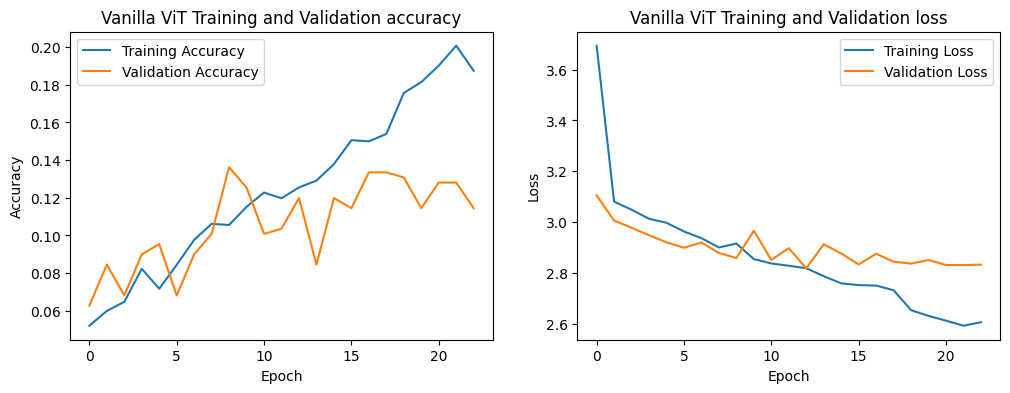

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1205 - loss: 2.8149 - top-3-accuracy: 0.2835
Val acc = 0.11989101022481918, val loss = 2.817955493927002, val_top_3_acc = 0.29427793622016907


In [18]:
plot_training_history(vanila_vit_history, "Vanilla ViT Training and Validation")
val_loss, val_acc, val_top_3_acc = vit_model.evaluate(val_ds)
print(f"Val acc = {val_acc}, val loss = {val_loss}, val_top_3_acc = {val_top_3_acc}")
results_df.append({"model_type": "vanilla_vit", "best_training_accuracy": max(vanila_vit_history.history['accuracy']),
                   "validation_accuracy": val_acc, "validation_top_3":val_top_3_acc})

In [19]:
# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
vit_sl_history = train_vit_model(vit_sl, 100)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 60s 238ms/step - accuracy: 0.0604 - loss: 4.2886 - top-3-accuracy: 0.1718 - val_accuracy: 0.0790 - val_loss: 2.9749 - val_top-3-accuracy: 0.2098 - learning_rate: 0.0010
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.0715 - loss: 3.0851 - top-3-accuracy: 0.1834 - val_accuracy: 0.0817 - val_loss: 2.9648 - val_top-3-accuracy: 0.1962 - learning_rate: 0.0010
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.0718 - loss: 3.0530 - top-3-accuracy: 0.2015 - val_accuracy: 0.0790 - val_loss: 2.9353 - val_top-3-accuracy: 0.2507 - learning_rate: 0.0010
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 23s 220ms/step - accuracy: 0.0791 - loss: 3.0117 - top-3-accuracy: 0.2042 - val_accuracy: 0.0872 - val_loss: 2.9426 - val_top-3-accuracy: 0.2153 - learning_rate: 0.0010
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - accuracy: 0.0858 - loss: 2.9641 - top-3-accuracy: 0.2162 - val_accuracy: 0.1226 - val_loss: 2.8980 - v

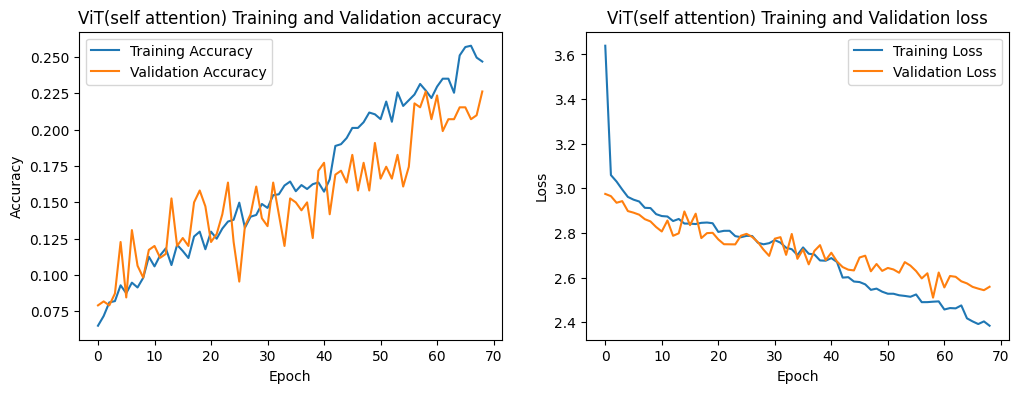

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2548 - loss: 2.4530 - top-3-accuracy: 0.4949
Val acc = 0.2261580377817154, val loss = 2.5098989009857178, val_top_3_acc = 0.47411444783210754


In [20]:
plot_training_history(vit_sl_history, "ViT(self attention) Training and Validation")
val_loss, val_acc, val_top_3_acc = vit_sl.evaluate(val_ds)
print(f"Val acc = {val_acc}, val loss = {val_loss}, val_top_3_acc = {val_top_3_acc}")
results_df.append({"model_type": "self_attention_vit", "best_training_accuracy": max(vit_sl_history.history['accuracy']), 
                   "validation_accuracy": val_acc, "validation_top_3":val_top_3_acc})

### CNN  based model
CNN is most robust and widely used technique for image classification.

A Convolutional Neural Network (CNN) works by using specialized layers called convolutional layers to automatically learn patterns directly from images. These layers act as a collection of digital filters that slide across the image, identifying specific features like edges, textures, or corners. A key advantage is that these same filters are applied uniformly across the entire image, enabling the network to recognize a pattern regardless of its position, a concept known as translation equivariance. Between these filtering steps, pooling layers condense the information, making the network more robust to slight variations in the image while also reducing its complexity. Through multiple such layers, a CNN builds a hierarchical understanding: starting with simple, low-level features and progressively combining them to form highly abstract, high-level representations. This design makes CNNs exceptionally effective for tasks requiring visual understanding, as they naturally align with the structural properties of image data.

In [21]:
# Model configuration
NUM_CLASSES = 20
DROPOUT_RATE = 0.5
L2_REG = 0.001
INITIAL_LR = 0.001

def build_deep_cnn_model(input_shape, num_classes):
    """
    Build a deep CNN with regularization
    """
    model = tf.keras.models.Sequential([
        # Input layer
        layers.InputLayer(input_shape=input_shape),

        # First convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(DROPOUT_RATE/2),

        # Second convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(DROPOUT_RATE),

        # Third convolutional block (deeper)
        layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(DROPOUT_RATE),

        # Fourth convolutional block
        layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(DROPOUT_RATE),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(1024, activation='relu',
                   kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
        layers.BatchNormalization(),
        layers.Dropout(DROPOUT_RATE),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(DROPOUT_RATE),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [22]:
def train_cnn_model(model, epochs):
    # Compile the model
    optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    model.compile(optimizer=optimizer,
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[
                      keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                      keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),])

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop_callback, reduce_lr_callback]
    )

    return history

In [23]:
# Build the model
cnn_model = build_deep_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), num_classes=NUM_CLASSES)

/home/manpreet/msds/deep_learning/repo/MSDS-5511-manpreet/final/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [24]:
cnn_model_history = train_cnn_model(cnn_model, 100)

Epoch 1/100


/home/manpreet/msds/deep_learning/repo/MSDS-5511-manpreet/final/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1751880477.205467   38183 service.cc:152] XLA service 0x7f05bc012bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751880477.205570   38183 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-07-07 09:27:57.551929: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-07 09:28:00.123795: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm en

103/104 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0590 - loss: 6.4037 - top-3-accuracy: 0.1725

2025-07-07 09:28:17.337108: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.25 = (f32[11,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,64,32,32]{3,2,1,0} %bitcast.27082, f32[64,64,3,3]{3,2,1,0} %bitcast.24543, f32[64]{0} %bitcast.27144), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/home/manpreet/msds/deep_learning/repo/MSDS-5511-manpreet/final/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-07 09:28:17.445967: I external/local_xla/xla/service/gpu/

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.0590 - loss: 6.4020 - top-3-accuracy: 0.1728

2025-07-07 09:28:27.243247: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.25 = (f32[32,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,32,32]{3,2,1,0} %bitcast.1404, f32[64,64,3,3]{3,2,1,0} %bitcast.1411, f32[64]{0} %bitcast.1413), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/home/manpreet/msds/deep_learning/repo/MSDS-5511-manpreet/final/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-07 09:28:27.404529: I external/local_xla/xla/service/gpu/aut

104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 198ms/step - accuracy: 0.0591 - loss: 6.4002 - top-3-accuracy: 0.1730 - val_accuracy: 0.0518 - val_loss: 14.6119 - val_top-3-accuracy: 0.1471 - learning_rate: 0.0010
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.0864 - loss: 5.8407 - top-3-accuracy: 0.2109 - val_accuracy: 0.1008 - val_loss: 5.7516 - val_top-3-accuracy: 0.2589 - learning_rate: 0.0010
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.1107 - loss: 5.5010 - top-3-accuracy: 0.2680 - val_accuracy: 0.1090 - val_loss: 5.3988 - val_top-3-accuracy: 0.2779 - learning_rate: 0.0010
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1343 - loss: 5.1742 - top-3-accuracy: 0.3259 - val_accuracy: 0.1362 - val_loss: 5.0932 - val_top-3-accuracy: 0.3134 - learning_rate: 0.0010
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1577 - loss: 4.9379 - top-3-accuracy: 0.3608 - val_accuracy: 0.1471 - val_loss: 4.6976 - val_top-3-accuracy: 

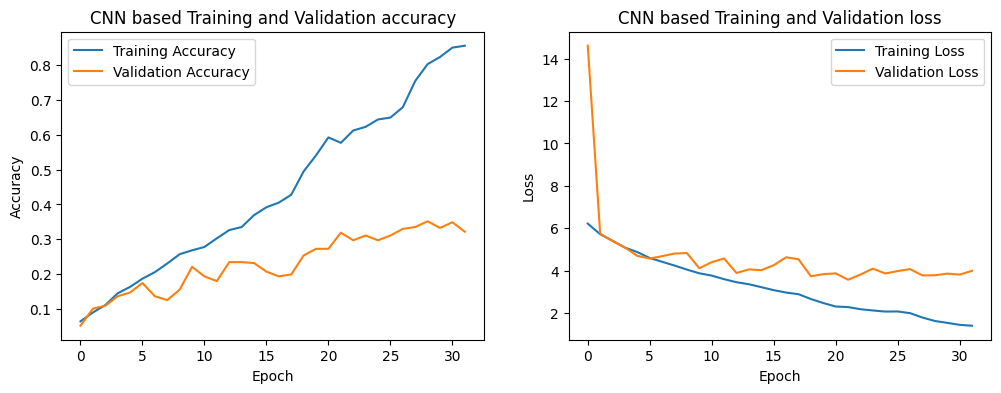

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3246 - loss: 3.4849 - top-3-accuracy: 0.5849
Val acc = 0.31880107522010803, val loss = 3.5727267265319824, val_top_3_acc = 0.5749318599700928


In [25]:
# Evaluate the model
plot_training_history(cnn_model_history, "CNN based Training and Validation")
val_loss, val_acc, val_top_3_acc = cnn_model.evaluate(val_ds)
print(f"Val acc = {val_acc}, val loss = {val_loss}, val_top_3_acc = {val_top_3_acc}")
results_df.append({"model_type": "CNN", "best_training_accuracy": max(cnn_model_history.history['accuracy']),
                   "validation_accuracy": val_acc, "validation_top_3":val_top_3_acc})

### Efficient net model
EfficientNet is a family of CNN architectures that achieves impressive performance while maintaining high efficiency through a clever compound scaling method. Instead of arbitrarily scaling network depth, width, or resolution, EfficientNet uniformly scales all three dimensions using a fixed set of scaling coefficients. This principled approach, derived through a neural architecture search, allows EfficientNet models to achieve a superior balance between accuracy and computational cost across various scales. This means you can get better performance with fewer resources by consistently increasing the network's capacity in a balanced way, making it a highly practical choice for many computer vision tasks.

In [26]:
def build_efficientnet_model(input_shape, num_classes):
    """
    Build EfficientNetB0 model with augmentation and custom head
    """
    # Base model (pre-trained model)
    base_model = EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    base_model.trainable = False  # Freeze base model 

    # Build full model with augmentation
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.Dropout(DROPOUT_RATE)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [27]:
def train_efficientnet_model(model, epochs):
    optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    model.compile(optimizer=optimizer,
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[
                      keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                      keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),])
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop_callback, reduce_lr_callback]
        )
    
    return history

In [28]:
efficientnet_model = build_efficientnet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), num_classes=NUM_CLASSES)

In [29]:
efficientnet_history = train_efficientnet_model(efficientnet_model, 100)

Epoch 1/100


E0000 00:00:1751880666.766053   37962 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - accuracy: 0.0580 - loss: 3.1308 - top-3-accuracy: 0.1722 - val_accuracy: 0.0545 - val_loss: 3.0259 - val_top-3-accuracy: 0.1689 - learning_rate: 0.0010
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.0623 - loss: 3.1134 - top-3-accuracy: 0.1732 - val_accuracy: 0.0490 - val_loss: 3.0327 - val_top-3-accuracy: 0.1689 - learning_rate: 0.0010
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.0489 - loss: 3.1173 - top-3-accuracy: 0.1622 - val_accuracy: 0.0627 - val_loss: 3.0204 - val_top-3-accuracy: 0.1744 - learning_rate: 0.0010
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.0618 - loss: 3.1106 - top-3-accuracy: 0.1638 - val_accuracy: 0.0545 - val_loss: 3.0271 - val_top-3-accuracy: 0.1853 - learning_rate: 0.0010
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.0560 - loss: 3.0913 - top-3-accuracy: 0.1720 - val_accuracy: 0.0572 - val_loss: 3.0333 - val_top-3-accuracy: 0

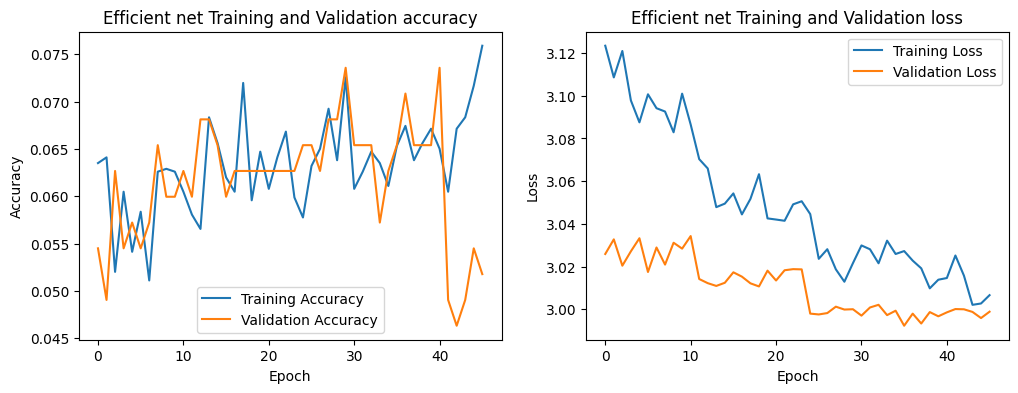

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0633 - loss: 2.9894 - top-3-accuracy: 0.2167
Val acc = 0.06539509445428848, val loss = 2.9922616481781006, val_top_3_acc = 0.21253405511379242


In [30]:
plot_training_history(efficientnet_history, "Efficient net Training and Validation")
val_loss, val_acc, val_top_3_acc = efficientnet_model.evaluate(val_ds)
print(f"Val acc = {val_acc}, val loss = {val_loss}, val_top_3_acc = {val_top_3_acc}")
results_df.append({"model_type": "efficient net", "best_training_accuracy": max(efficientnet_history.history['accuracy']), 
                   "validation_accuracy": val_acc, "validation_top_3":val_top_3_acc})

### Resnet 50
ResNet-50 is another CNN architecture that revolutionized deep learning by effectively addressing the vanishing gradient problem in very deep networks. It achieves this primarily through the ingenious use of "residual connections" or "skip connections," which allow the input from a previous layer to be directly added to the output of a later layer, bypassing one or more convolutional layers. This enables the training of much deeper networks (hence "ResNet" for Residual Network) without degradation in performance, as the shortcut paths ensure that gradients can flow more easily through the network during backpropagation.

In [31]:
def build_resnet_model(input_shape, num_classes):
    """
    Build Resnet model
    """
    # Base model (pre-trained model)
    base_model = ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    base_model.trainable = False  # Freeze base model 

    # Build full model with augmentation
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.Dropout(DROPOUT_RATE)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [32]:
def train_resnet_model(model, epochs):
    optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    model.compile(optimizer=optimizer,
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[
                      keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                      keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),])
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop_callback, reduce_lr_callback]
        )
    
    return history

In [33]:
resnet_model = build_resnet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), num_classes=NUM_CLASSES)
resnet_history = train_resnet_model(resnet_model, 100)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.0683 - loss: 3.3073 - top-3-accuracy: 0.1790 - val_accuracy: 0.0954 - val_loss: 3.2474 - val_top-3-accuracy: 0.2207 - learning_rate: 0.0010
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.1024 - loss: 3.0910 - top-3-accuracy: 0.2253 - val_accuracy: 0.1144 - val_loss: 3.2737 - val_top-3-accuracy: 0.2289 - learning_rate: 0.0010
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.1036 - loss: 2.9882 - top-3-accuracy: 0.2555 - val_accuracy: 0.1117 - val_loss: 3.2934 - val_top-3-accuracy: 0.2452 - learning_rate: 0.0010
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1188 - loss: 2.9695 - top-3-accuracy: 0.2677 - val_accuracy: 0.1199 - val_loss: 3.2632 - val_top-3-accuracy: 0.2643 - learning_rate: 0.0010
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.1187 - loss: 2.9380 - top-3-accuracy: 0.2819 - val_accuracy: 0.1390 - val_loss: 3.2934 - val_top-3-

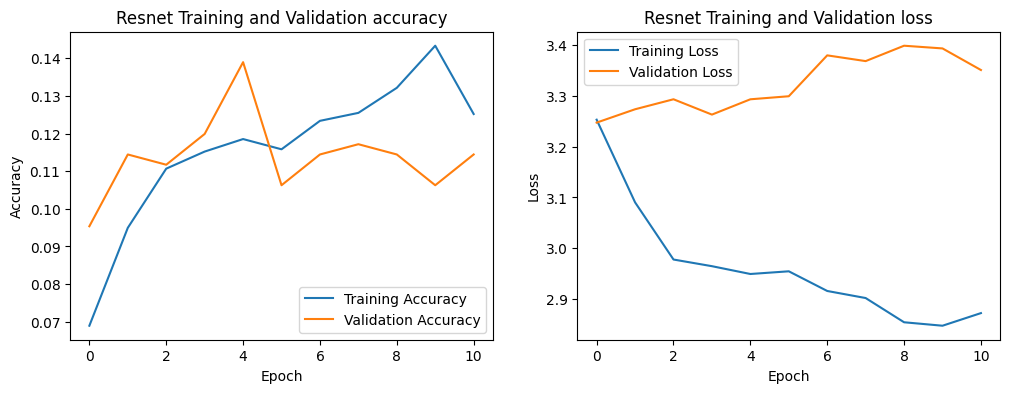

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1030 - loss: 3.1576 - top-3-accuracy: 0.2351
Val acc = 0.09536784887313843, val loss = 3.247427463531494, val_top_3_acc = 0.2207084447145462


In [34]:
plot_training_history(resnet_history, "Resnet Training and Validation")
val_loss, val_acc, val_top_3_acc = resnet_model.evaluate(val_ds)
print(f"Val acc = {val_acc}, val loss = {val_loss}, val_top_3_acc = {val_top_3_acc}")
results_df.append({"model_type": "resnet", "best_training_accuracy": max(resnet_history.history['accuracy']), 
                   "validation_accuracy": val_acc, "validation_top_3":val_top_3_acc})

### Results

In [35]:
#combining results
pd.DataFrame(results_df)

model_type  best_training_accuracy  validation_accuracy  \
0         vanilla_vit                0.200786             0.119891   
1  self_attention_vit                0.257635             0.226158   
2                 CNN                0.855458             0.318801   
3       efficient net                0.075900             0.065395   
4              resnet                0.143332             0.095368   

   validation_top_3  
0          0.294278  
1          0.474114  
2          0.574932  
3          0.212534  
4          0.220708

### Discussion/Conclusion

Based on observed results the <b>CNN based model</b> significantly outperformed other architectures, achieving the highest best training accuracy of 0.857877, validation accuracy of 0.318801, and validation top-3 accuracy of 0.591281. The self-attention ViT model showed the second-best performance across all metrics, suggesting the potential benefits of attention mechanisms in vision transformers, although it still lagged considerably behind the CNN. Conversely, the EfficientNet and vanilla ViT models demonstrated the lowest performance, indicating their current configurations or inherent architectures were less suitable for this specific image classification task compared to CNNs or self-attention ViTs. ResNet also underperformed relative to the CNN and self-attention ViT. These findings highlight the strong applicability of convolutional neural networks for this classification problem and suggest further optimization or different architectural choices may be needed for the transformer and other models to reach comparable performance.

One major reason, CNN outperformed others architectures could be the size of data. Each of 20 image labels had images from 150-200 in count. Vision Transformers are known to be "data hungry" and this excercise reinforces it.

For large, complex CNNs like ResNet and EfficientNet, while they are CNN based, their massive capacity (depth and number of parameters) can still lead to overfitting on very small datasets without careful regularization or transfer learning.